# Occasionally binding constraint model - Time Iteration with JAX

This notebook solves the Bianchi (2011) model with occasionally binding collateral constraints using Adaptive Sparse Grids

## Model Setup and Calibration

In [1]:
# %%
import os
from collections import namedtuple
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap
import matplotlib.pyplot as plt
from quantecon.markov import tauchen

# Set JAX to use 64-bit floats for better precision
jax.config.update("jax_enable_x64", True)

# ---------------------------------------------------------------------------- #
#                                 MODEL SETUP                                  #
# ---------------------------------------------------------------------------- #

# Define a container for all model parameters and grids
Model = namedtuple('Model',
    ('σ', 'κ', 'β', 'ω', 'η', 'τ', 'i_l', 'yN',
     'l_grid', 'yT_grid', 'Π', 'n_l', 'n_s'))

def create_model(
        # --- Structural parameters --- #
        σ = 2.0,           # Inverse of intertemporal elasticity of consumption
        κ = 0.2808,      # Parameter in borrowing constraint
        β = 0.91,        # Subjective discount factor
        ω = 0.31,        # Weight on traded goods in CES aggregator
        η = 0.5,         # Elasticity of substitution between traded/non-traded goods
        τ = 0.2,         # Government default cost
        i_l = 0.05,      # Interest rate
        yN = 1.0,        # Endowment of non-traded goods
        # --- Income Process Parameters --- #
        yT_size = 5,
        ρy = 0.945,
        ηy = 0.025,
        # --- Grid Parameters --- #
        n_l = 400,
        l_min = 0.001,
        l_max = 0.85 # safe until 0.9
    ):
    """
    Creates and returns an instance of the Model namedtuple with all
    parameters and discretized grids.
    """
    # Discretize the income process using Tauchen
    mc = tauchen(yT_size, ρy, ηy, 0, 1.5)
    yT_grid_np = np.exp(mc.state_values)
    Π_np = mc.P
    n_s = yT_size

    # Create the asset grid
    l_grid_np = np.linspace(l_min, l_max, n_l)

    # Convert to JAX arrays
    yT_grid, Π, l_grid = jnp.array(yT_grid_np), jnp.array(Π_np), jnp.array(l_grid_np)

    return Model(σ=σ, κ=κ, β=β, ω=ω, η=η, τ=τ, i_l=i_l, yN=yN,
                 l_grid=l_grid, yT_grid=yT_grid, Π=Π, n_l=n_l, n_s=n_s)


## JAX Helper Functions

In [2]:

# ---------------------------------------------------------------------------- #
#                         JAX-Optimized Helper Functions                       #
# ---------------------------------------------------------------------------- #

def dudcT(model, ct):
    """
    Marginal utility of traded consumption, parameterized by the model object.
    """
    ξ, a, σ, yn = model.η, model.ω, model.σ, model.yN
    return jnp.where(
        ct > 1e-9,
        a * ct**(-1/ξ) * (a * ct**((ξ-1)/ξ) + (1-a) * yn**((ξ-1)/ξ))**((1 - σ*ξ)/(ξ-1)),
        999_999.0
    )

# ---------------------------------------------------------------------------- #


## Vectorized Solver (JIT Compiled)

In [3]:
#          Vectorized Solver for the Household's Problem                     #
# ---------------------------------------------------------------------------- #

def solve_single_state(model, l, yT, pn, e_lambda_col):
    """
    Solves for the optimal next-period asset holding (l') for a single
    state (l, yT).
    """
    # Unpack model parameters
    κ, τ, i_l, yN, β, l_grid = model.κ, model.τ, model.i_l, model.yN, model.β, model.l_grid

    # 1. Calculate borrowing constraint
    borr_const = κ * (pn * yN + yT * (1 - τ))

    # 2. Grid search over all possible next-period assets (l')
    ct_vec = yT * (1 - τ) - l + l_grid / (1 + i_l)
    dudcT_vec = vmap(dudcT, in_axes=(None, 0))(model, jnp.maximum(ct_vec, 1e-9))
    euler_residual = dudcT_vec / (1 + i_l) - β * e_lambda_col

    # 3. Find l' that minimizes the Euler residual
    lp_idx = jnp.argmin(jnp.abs(euler_residual))
    l_prime_candidate = l_grid[lp_idx]

    # 4. Enforce the borrowing constraint
    l_prime_optimal = jnp.minimum(l_prime_candidate, borr_const)

    # 5. Calculate resulting consumption and multiplier
    ct_optimal = yT * (1 - τ) - l + l_prime_optimal / (1 + i_l)
    mu_val = dudcT(model, ct_optimal) / (1 + i_l) - β * e_lambda_col[lp_idx]

    return l_prime_optimal, ct_optimal, mu_val

# Vectorize the solver function to run across the entire state space at once.
# First, vmap over all income states 's' for a given asset level 'l'.
vmap_over_s = vmap(solve_single_state, in_axes=(None, None, 0, 0, 1))
# Now, vmap the function above over all asset levels 'l'.
solve_all_states = vmap(vmap_over_s, in_axes=(None, 0, None, 0, None))

@jit
def time_iteration_step(model, policies):
    """
    Performs one full update of the policy functions. JIT-compiled for performance.
    """
    LP_prev, CT_prev, PN_prev = policies

    # 1. Calculate current period marginal utility of consumption
    lambda_prev = vmap(vmap(dudcT, in_axes=(None, 0)), in_axes=(None, 0))(model, CT_prev)

    # 2. Calculate expected marginal utility for the next period
    E_lambda = lambda_prev @ model.Π.T

    # 3. Solve for optimal policies for ALL states simultaneously
    LP_next, CT_next, MU_next = solve_all_states(
        model, model.l_grid, model.yT_grid, PN_prev, E_lambda
    )

    # 4. Calculate the new price of non-traded goods
    PN_next = (1 - model.ω) / model.ω * (CT_next / model.yN)**(1 / model.η)

    return LP_next, CT_next, PN_next, MU_next

# ---------------------------------------------------------------------------- #
#                               Main Solver Loop                               #
# ---------------------------------------------------------------------------- #


## Main Solution Loop

In [4]:

def solve_model(tol=1e-5, n_iter=500, updt=0.2):
    """
    Main function to solve the household's problem via time iteration.
    """
    # --- Create model instance --- #
    model = create_model()
    l_grid, yT_grid = model.l_grid, model.yT_grid
    n_l, n_s = model.n_l, model.n_s

    # --- Initial Guesses --- #
    L = l_grid.reshape(-1, 1)
    LP_0 = jnp.tile(l_grid.reshape(-1, 1), (1, n_s))
    CT_0 = jnp.tile(yT_grid, (n_l, 1)) * (1 - model.τ) - L + LP_0 / (1 + model.i_l)
    PN_0 = (1 - model.ω) / model.ω * (jnp.maximum(CT_0, 1e-9) / model.yN)**(1 / model.η)

    print("--- Starting JAX Time Iteration ---")
    for iter_num in range(n_iter):
        # Perform one full, JIT-compiled update step
        LP, CT, PN, MU = time_iteration_step(model, (LP_0, CT_0, PN_0))

        # Check for Convergence
        dist = jnp.max(jnp.abs(LP - LP_0))
        if dist < tol:
            print(f"\nConverged at iteration {iter_num + 1} with distance: {dist:.2e}")
            return model, LP, PN, MU

        if iter_num % 10 == 0:
            print(f"Iter: {iter_num + 1:<4} | Distance: {dist:.4e}")

        # Damped Update for Stability
        LP_0 = (1 - updt) * LP_0 + updt * LP
        CT_0 = (1 - updt) * CT_0 + updt * CT
        PN_0 = (1 - updt) * PN_0 + updt * PN

    print(f"\nWarning: Did not converge after {n_iter} iterations.")
    return model, LP, PN, MU


## Visualization and Results

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1174447/4044857485.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_title("Kuhn-Tucker Multiplier: $\mu(l,s)$")
/tmp/ipykernel_1174447/4044857485.py:26: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('Multiplier ($\mu$)')


--- Starting JAX Time Iteration ---
Iter: 1    | Distance: 3.6673e-01
Iter: 11   | Distance: 1.2190e-01
Iter: 21   | Distance: 5.0308e-02
Iter: 31   | Distance: 2.3541e-02
Iter: 41   | Distance: 1.3811e-02
Iter: 51   | Distance: 9.2060e-03
Iter: 61   | Distance: 6.6495e-03
Iter: 71   | Distance: 5.0798e-03
Iter: 81   | Distance: 4.0265e-03
Iter: 91   | Distance: 3.3086e-03
Iter: 101  | Distance: 2.6873e-03
Iter: 111  | Distance: 2.2398e-03
Iter: 121  | Distance: 1.8765e-03
Iter: 131  | Distance: 1.5584e-03
Iter: 141  | Distance: 1.2848e-03
Iter: 151  | Distance: 2.1278e-03
Iter: 161  | Distance: 2.1278e-03
Iter: 171  | Distance: 7.9889e-04
Iter: 181  | Distance: 6.8675e-04
Iter: 191  | Distance: 2.1278e-03
Iter: 201  | Distance: 6.9724e-04
Iter: 211  | Distance: 4.2870e-04
Iter: 221  | Distance: 3.6474e-04
Iter: 231  | Distance: 1.0894e-03
Iter: 241  | Distance: 1.0894e-03
Iter: 251  | Distance: 2.3791e-04
Iter: 261  | Distance: 2.1879e-04
Iter: 271  | Distance: 2.0100e-04
Iter: 281  |

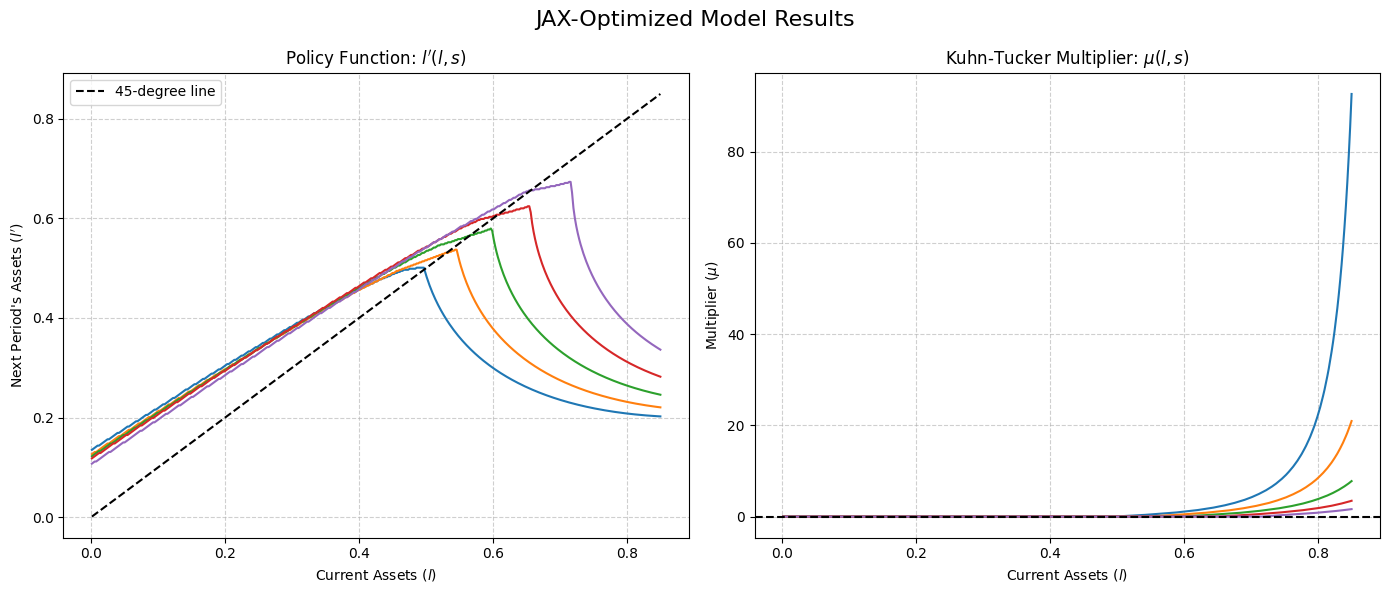

In [6]:
if __name__ == '__main__':
    # --- Solve the model --- #
    model, LP_policy, PN_policy, mu_policy = solve_model(tol=1e-6, n_iter=1000, updt=0.2)

    # --- Visualization --- #
    # Convert JAX arrays back to NumPy for plotting
    l_grid_np = np.array(model.l_grid)
    LP_policy_np = np.array(LP_policy)
    mu_policy_np = np.array(mu_policy)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
    fig.suptitle("JAX-Optimized Model Results", fontsize=16)

    ax1.plot(l_grid_np, LP_policy_np)
    ax1.plot(l_grid_np, l_grid_np, linestyle='--', color='black', label='45-degree line')
    ax1.set_title("Policy Function: $l'(l,s)$")
    ax1.set_xlabel('Current Assets ($l$)')
    ax1.set_ylabel("Next Period's Assets ($l'$)")
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    ax2.plot(l_grid_np, mu_policy_np)
    ax2.axhline(0, linestyle='--', color='black')
    ax2.set_title("Kuhn-Tucker Multiplier: $\mu(l,s)$")
    ax2.set_xlabel('Current Assets ($l$)')
    ax2.set_ylabel('Multiplier ($\mu$)')
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.show()


# %%
